# Table of Contents
 <p>

In [1]:
import pandas as pd
import numpy as np
import scipy as scipy
import sklearn.decomposition
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import os
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})


%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
strains =['ps4187', 'ps4087', 'ps4176', 'ew15', 'mt21245', 'mt4866','n2731', 'n2376', 'n767', 'n2731-n767', 'tm1489',
          'n3809', 'n3917', 'n745', 'n767-tm1489', 'n2731-tm1489',
          'ia4', 'ok1402', 'ok161', 'sa307', 'sa307-ok161', 'sa307-ia4',
          'q71']

strain_dict = {}
for i, g in enumerate(strains):
    strain_dict[g] = i

In [3]:
q = 0.1

In [4]:
genmap = pd.read_csv('../sleuth/rna_seq_info.txt', sep=' ', comment='#')
frames = []

for root, dirs, files in os.walk("../sleuth/sleuth_strains"):
    for file in files:
        if file == 'lrt.csv':
            continue
            
        strain =  file[:-4].replace('_', '-')
        
        df = pd.read_csv(root + '/' + file, sep=',')
        df.sort_values('target_id', inplace=True)
        df['strain'] = strain.replace('b-', '')
        df['genotype'] = genmap[genmap.strain == file[:-4]].genotype.unique()[0].replace('b_', '').replace('_', '-')
        df['order'] = strain_dict[df.strain.unique()[0]]
        frames += [df]
    
tidy = pd.concat(frames)
tidy.dropna(subset=['ens_gene', 'b', 'qval'], inplace=True)
tidy['absb'] = tidy.b.abs()
tidy.sort_values(['order', 'target_id'], ascending=True, inplace=True)
tidy.head()

tidy.to_csv('../input/quantifications.csv', index=False)

In [5]:
total_genes_id = tidy.target_id.unique().shape[0]
print("Total isoforms identified in all genotypes: {0}".format(total_genes_id))

Total isoforms identified in all genotypes: 21800


In [6]:
print('Genotype, Strain: DEG')
for x in tidy.strain.unique():
    # select the DE isoforms in the current genotype:
    sel = (tidy.qval < q) & (tidy.strain == x)
    # extract the number of unique genes:
    s = tidy[sel].ens_gene.unique().shape[0]
    genotype = tidy[tidy.strain == x].genotype.unique()[0]
    print(
          """{0}, {1}: {2}""".format(genotype, x, s))

Genotype, Strain: DEG
dpy22-a1, ps4187: 434
dpy22-a2, ps4087: 2821
dpy22-a1a2het, ps4176: 2930
bar1, ew15: 5405
let60-gf, mt21245: 3021
let60-lf, mt4866: 857
lin8, n2731: 1068
lin8nc, n2376: 628
lin15a, n767: 58
lin8-lin15a, n2731-n767: 265
hpl2, tm1489: 2217
lin61, n3809: 2799
lnes1, n3917: 699
lin35, n745: 2788
lin15a-hpl2, n767-tm1489: 7398
lin8-hpl2, n2731-tm1489: 3016
hif1, ia4: 2993
rhy1, ok1402: 4447
vhl1, ok161: 2579
egl9, sa307: 4034
egl9-vhl1, sa307-ok161: 5409
egl9-hif1, sa307-ia4: 1979
fog2, q71: 2805


In [7]:
frames = []

for root, dirs, files in os.walk("../sleuth/sleuth_batches/"):
    for file in files:        
        df = pd.read_csv(root + '/' + file, sep=',')
        df.sort_values('target_id', inplace=True)
        df['batch'] = file[:-4]
        frames += [df]
batches = pd.concat(frames)

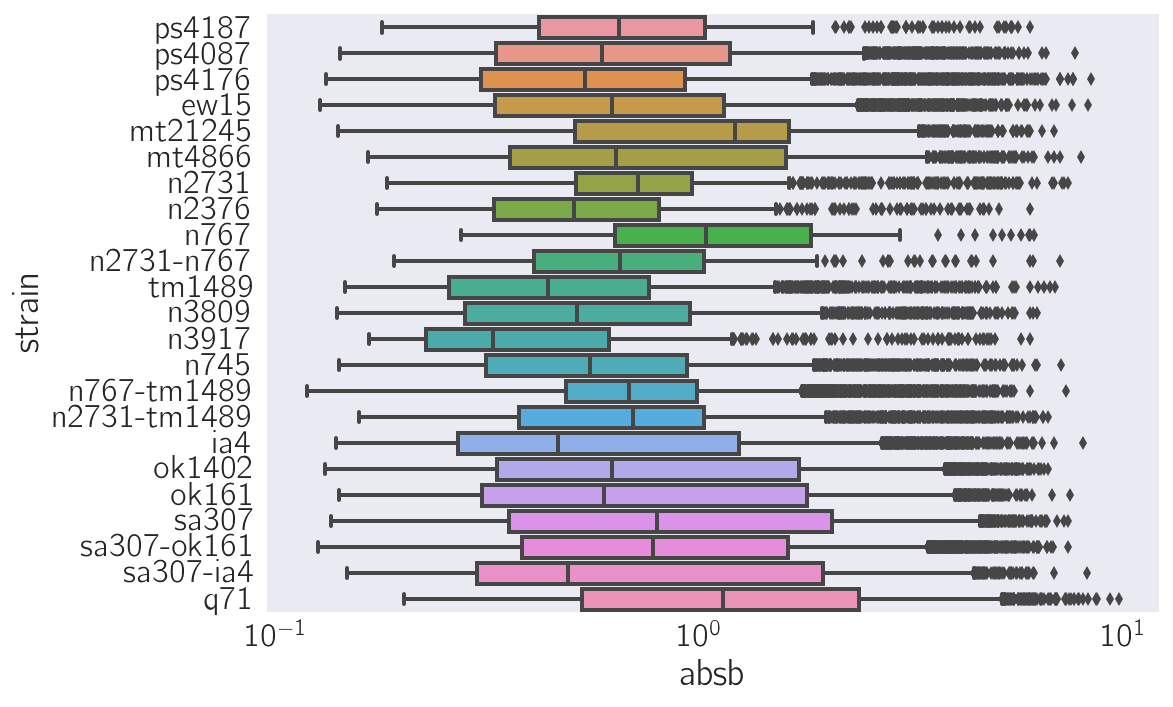

In [8]:
sns.boxplot(x='absb', y='strain', data=tidy[tidy.qval < q])
plt.xscale('log')

In [9]:
sig = (tidy.qval < q)
print('pair, shared GENES, percent shared (isoforms)')
for i, g1 in enumerate(tidy.strain.unique()):
    genes1 = tidy[sig & (tidy.strain == g1)]
    for j, g2 in enumerate(tidy.strain.unique()[i+1:]):
        genes2 = tidy[sig & (tidy.strain == g2)]
        
        # find the overlap between the two:
        n = genes2[genes2.ens_gene.isin(genes1.ens_gene)].shape[0]
        OR = ((tidy.strain == g1) | (tidy.strain == g2)) 
        size1 = tidy[(tidy.strain == g1) & (tidy.qval < q)].shape[0]
        size2 = tidy[(tidy.strain == g1) & (tidy.qval < q)].shape[0]
        
        n_iso = genes2[genes2.target_id.isin(genes1.target_id)].shape[0]
        ntot = len(tidy[sig & OR].target_id.unique())
        if n_iso/np.min([size1, size2]) > .50:
            print(
                "{0}---{1}, {2}, {3:.2g}%, {4:.2g}%".format(g1, g2, n_iso, 100*n_iso/ntot, 100*n_iso/np.min([size1, size2]))
                 )

pair, shared GENES, percent shared (isoforms)
ps4187---ps4087, 322, 11%, 73%
ps4187---ps4176, 314, 9.7%, 71%
ps4187---ew15, 323, 5.5%, 73%
ps4187---mt21245, 223, 6.7%, 51%
ps4187---n767-tm1489, 254, 3.1%, 58%
ps4187---ok1402, 249, 5%, 57%
ps4187---sa307, 256, 5.6%, 58%
ps4187---sa307-ok161, 265, 4.4%, 60%
ps4087---ew15, 1873, 28%, 64%
ps4087---n767-tm1489, 1658, 18%, 57%
ps4087---sa307-ok161, 1584, 22%, 54%
ps4176---ew15, 1892, 27%, 61%
ps4176---n767-tm1489, 1883, 20%, 60%
ew15---n767-tm1489, 3471, 34%, 61%
ew15---sa307-ok161, 2977, 35%, 52%
mt21245---n767-tm1489, 1648, 17%, 53%
mt21245---sa307-ok161, 1823, 26%, 59%
mt4866---n767-tm1489, 520, 6.2%, 58%
mt4866---sa307, 450, 9.4%, 50%
n2731---n767-tm1489, 572, 6.7%, 53%
n2731---n2731-tm1489, 804, 24%, 74%
n2731---sa307-ok161, 721, 12%, 66%
n2376---n767-tm1489, 422, 5.1%, 66%
n2376---sa307-ok161, 334, 5.4%, 52%
n767---n2731-n767, 31, 11%, 53%
n767---tm1489, 38, 1.7%, 66%
n767---n745, 35, 1.2%, 60%
n767---n767-tm1489, 41, 0.51%, 71%
n2731-